## **Traditional Approach**
This notebook contains the code and implementation details (for Facial Expression Recognition using FER2013 dataset in this case) using **traditional method**. This serves as a baseline to compare to our proposed **Divide2Conquer (D2C)** method which aims to address the issue of **Overfitting** in Deep Learning models. We used the same CNN based model we used in our method to train each of the subsets, so that there can be a fair camparison between the approaches.

## **Importing Necessary Packages & Mounting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import random
import cv2
import os
import sys
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, accuracy_score

sys.path.append('/content/drive/MyDrive/IAR Research Grant/Codes/Refined Codes')
from d2c_utils import *

In [ ]:
!pip install tf_keras

## **Loading Dataset & Data Preprocessing**

In [4]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir,
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        im_gray_resized = cv2.resize(im_gray, (48,48), interpolation = cv2.INTER_AREA)
        #image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(im_gray_resized/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels

In [5]:
!unzip "/content/FER.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [6]:
#declare path to the data folder
img_path = '/content/train'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply the function
image_list, label_list = load(image_paths, verbose=1000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

#split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(image_list,
                                                    label_list,
                                                    test_size=0.1,
                                                    random_state=8)

[INFO] processed 1000/28709
[INFO] processed 2000/28709
[INFO] processed 3000/28709
[INFO] processed 4000/28709
[INFO] processed 5000/28709
[INFO] processed 6000/28709
[INFO] processed 7000/28709
[INFO] processed 8000/28709
[INFO] processed 9000/28709
[INFO] processed 10000/28709
[INFO] processed 11000/28709
[INFO] processed 12000/28709
[INFO] processed 13000/28709
[INFO] processed 14000/28709
[INFO] processed 15000/28709
[INFO] processed 16000/28709
[INFO] processed 17000/28709
[INFO] processed 18000/28709
[INFO] processed 19000/28709
[INFO] processed 20000/28709
[INFO] processed 21000/28709
[INFO] processed 22000/28709
[INFO] processed 23000/28709
[INFO] processed 24000/28709
[INFO] processed 25000/28709
[INFO] processed 26000/28709
[INFO] processed 27000/28709
[INFO] processed 28000/28709


In [7]:
X_train = tf.stack(X_train)
y_train = tf.stack(y_train)
X_val = tf.stack(X_val)
y_val = tf.stack(y_val)

In [8]:
#declare path to your test data folder
test_img_path = '/content/test'

#get the path list using the path object
test_image_paths = list(paths.list_images(test_img_path))

#apply our function
test_image_list, test_label_list = load(test_image_paths, verbose=1000)

#binarize the labels
lb = LabelBinarizer()
test_label_list = lb.fit_transform(test_label_list)

X_Test, y_Test = test_image_list, test_label_list
X_Test = tf.stack(X_Test)
y_Test = tf.stack(y_Test)

[INFO] processed 1000/7178
[INFO] processed 2000/7178
[INFO] processed 3000/7178
[INFO] processed 4000/7178
[INFO] processed 5000/7178
[INFO] processed 6000/7178
[INFO] processed 7000/7178


# **Model Training**
The Network Architecture is shown in the picture below..
<div style="text-align: center;">
    <img src="CNN_Horizontal.png" alt="The CNN based Model" width="1200"/>
</div>

In [39]:
batch_size = 32
num_classes = 7
epochs = 80
input_shape = (48,48,1)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 48X48 with 1 byte color
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 128 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu',  kernel_initializer='he_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # 7 output neurons.
    ## tf.keras.layers.Dense(num_classes, activation='softmax')
    tf.keras.layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [41]:
model.save('/content/drive/MyDrive/IAR Research Grant/Codes/Image Classification Codes/FER2013/model_no_subset.keras')

In [42]:
checkpoint_filepath = '/content/drive/MyDrive/IAR Research Grant/Codes/Image Classification Codes/FER2013/model_no_subset.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

model = tf.keras.models.load_model(checkpoint_filepath)

print("Training Complete")

Epoch 1/80
808/808 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.2197 - loss: 2.3016 - val_accuracy: 0.3804 - val_loss: 1.5907
Epoch 2/80
808/808 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4156 - loss: 1.5279 - val_accuracy: 0.4309 - val_loss: 1.4689
Epoch 3/80
808/808 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4961 - loss: 1.3332 - val_accuracy: 0.5273 - val_loss: 1.2433
Epoch 4/80
808/808 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5272 - loss: 1.2466 - val_accuracy: 0.5218 - val_loss: 1.2143
Epoch 5/80
808/808 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5561 - loss: 1.1801 - val_accuracy: 0.5406 - val_loss: 1.2173
Epoch 6/80
808/808 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5885 - loss: 1.1155 - val_accuracy: 0.5674 - val_loss: 1.1387
Epoch 7/80
808/808 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5991 - loss: 1.0749 - val_accuracy: 0.5852 - val_loss: 1.1155
Epoch 8/80
808/808 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6184 - loss: 1.0231 - val_accuracy: 

## **Model Validation**

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


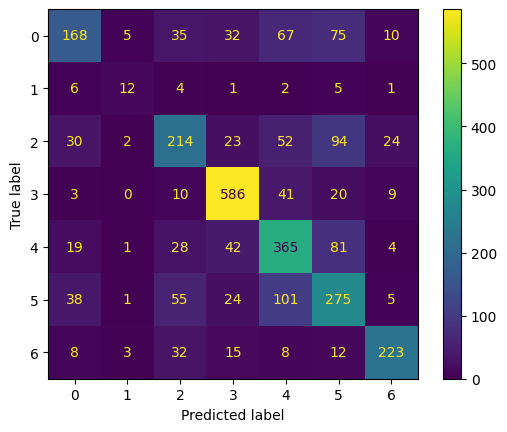

In [43]:
pred = tf.nn.softmax(model.predict(X_val))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_val, axis=1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [44]:
y_pred_proba = tf.nn.softmax(model.predict(X_val))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ROC_AUC Score: 0.8891684050896085
Cohen_Kappa Score: 0.5646079109680484
F1 Score: 0.602900050972755
Matthews Correlation Coefficient: 0.5660838607584087
Log Loss: 1.9723542354604848
Accuracy: 0.6419366074538488


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Text(0, 0.5, 'Loss')

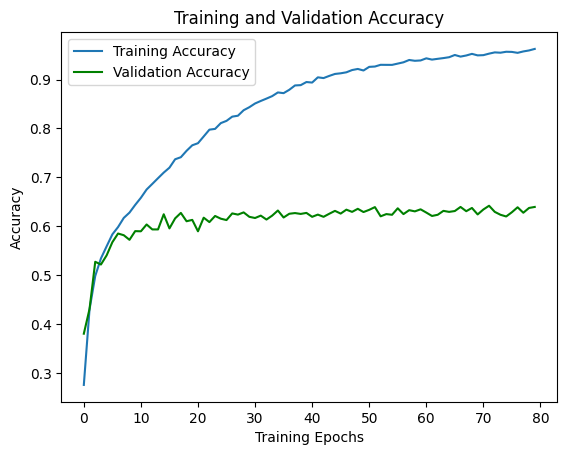

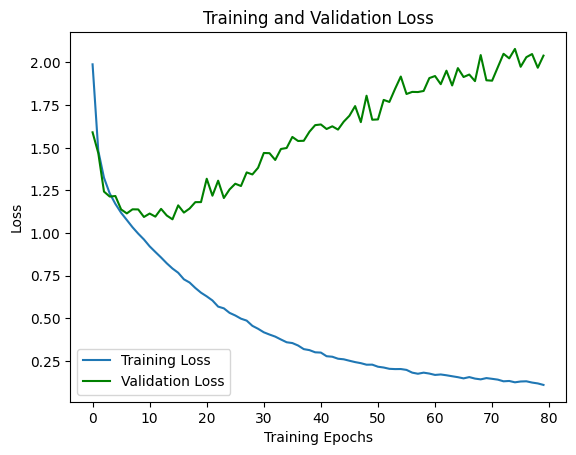

In [45]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = hist.history[     'accuracy' ]
val_acc  = hist.history[ 'val_accuracy' ]
loss     = hist.history[    'loss' ]
val_loss = hist.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
plt.title ('Training and Validation Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
plt.title ('Training and Validation Loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Training Epochs')
plt.ylabel('Loss')

## **Test Set Evaluation**

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


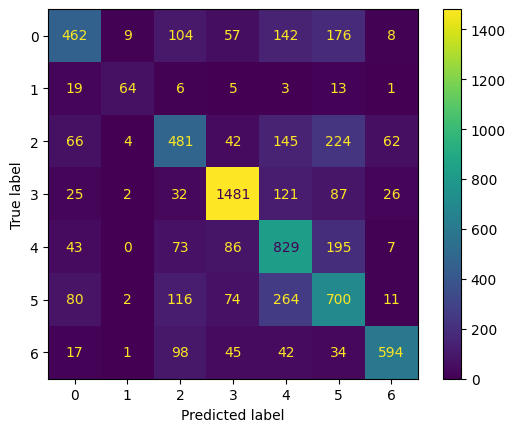

In [46]:
pred = tf.nn.softmax(model.predict(X_Test))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_Test, axis = 1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [47]:
y_pred_proba = tf.nn.softmax(model.predict(X_Test))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ROC_AUC Score: 0.8959538284161442
Cohen_Kappa Score: 0.565915908155108
F1 Score: 0.6337463094247402
Matthews Correlation Coefficient: 0.5674039013971963
Log Loss: 1.9533479328684098
Accuracy: 0.6423794928949568


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
